## Import Necessary Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
path  = '/ocean/projects/atm200007p/'
e3sm  = np.squeeze(xr.open_dataset(path+'sferrett/e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
era5  = xr.open_dataset(path+'sferrett/era5/ERA5_2D_195906_202108_monthly.nc')
era5  = era5.reindex(latitude=era5.latitude[::-1]).rename({'longitude':'lon','latitude':'lat'})
imerg = xr.open_mfdataset(np.sort(glob.glob(path+'nanaliu/imerg/'+'*.nc4'))).transpose('time','lat','lon')

In [3]:
def createdataset(filename,a,b):
    with open(path+'sferrett/indices/'+filename) as file: datafile=file.readlines()
    datalist=[]
    for line in datafile[a:b]:datalist.append(line.strip().split())
    file.close()
    data=np.asarray(datalist)[:,1:].reshape(864,)
    dataset=xr.DataArray(data,coords=[pd.date_range('1950-01-01','2021-12-01',freq='MS')],
                         dims=['time']).astype('float16')
    return dataset
dmidata = createdataset('DMI_West_1870_2022.txt',81,-8)
onidata = createdataset('ONI_1950_2022.txt',1,-9)

## Standardize Data and Define Variables

In [4]:
lat1=10; lat2=20; lon1=60; lon2=90
z      = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/9.80665/1000
lon    = e3sm.lon.sel(lon=slice(lon1,lon2))
months = ['JUN','JUL','AUG']
names  = ['ERA5 (1959 - 2021)','IMERG (2000 - 2021)']
era5years  = 63
imergyears = 22

In [5]:
def transformlon(londata,prdata):
    lonslice  = londata.sel(lon=slice(lon1,lon2)).to_numpy()
    prprofile = prdata.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)).mean(dim='lat').to_numpy()
    transform = interpolate.interp1d(lonslice,prprofile,bounds_error=False)
    return transform(lon)
era5precip  = xr.DataArray(transformlon(era5.lon,era5.mtpr))*86400
imergprecip = xr.DataArray(transformlon(imerg.lon,imerg.precipitation))*24
era5pr  = xr.concat((era5precip[0::3],era5precip[1::3],era5precip[2::3]),dim='time')
imergpr = xr.concat((imergprecip[0::12],imergprecip[1::12],imergprecip[2::12]),dim='time')

In [6]:
dmi = xr.concat((dmidata[5::12],dmidata[6::12],dmidata[7::12]),dim='time').to_numpy().reshape(3,72)
oni = xr.concat((onidata[5::12],onidata[6::12],onidata[7::12]),dim='time').to_numpy().reshape(3,72)
era5dmi  = dmi[:,9:]
imergdmi = dmi[:,50:]
era5oni  = oni[:,9:]
imergoni = oni[:,50:]

## Plot Time Series of ENSO and IOD Indices

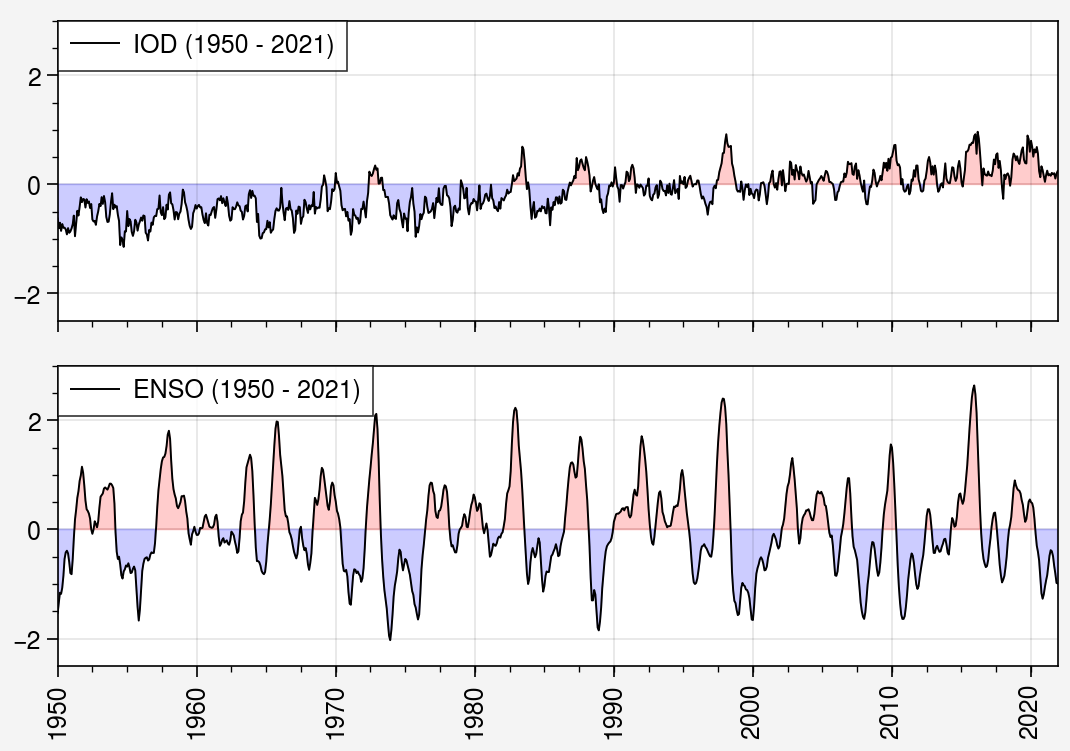

In [7]:
pplt.rc.reso='hi'; alpha=0.2; linewidth=0.7
fig,axs = pplt.subplots(ncols=1,nrows=2,refheight=1.5,refwidth=5,sharex=True,sharey=True)
axs.format(xlabel='',ylim=(-2.5,3))
axs[0].plot(dmidata.time,dmidata,'k',linewidth=linewidth,label='IOD (1950 - 2021)')
axs[0].fill_between(dmidata.time,dmidata,where=dmidata>0,color='r',alpha=alpha)
axs[0].fill_between(dmidata.time,dmidata,where=dmidata<0,color='b',alpha=alpha)
axs[0].legend(loc='ul')
axs[1].plot(onidata.time,onidata,'k',linewidth=linewidth,label='ENSO (1950 - 2021)')
axs[1].fill_between(onidata.time,onidata,where=onidata>0,color='r',alpha=alpha)
axs[1].fill_between(onidata.time,onidata,where=onidata<0,color='b',alpha=alpha)
axs[1].legend(loc='ul')

## Plot Upwind Profiles of Precipitation by IOD

In [8]:
era5meddmi = xr.zeros_like(era5pr)
era5posdmi = xr.zeros_like(era5pr)
era5negdmi = xr.zeros_like(era5pr)
imergmeddmi = xr.zeros_like(imergpr)
imergposdmi = xr.zeros_like(imergpr)
imergnegdmi = xr.zeros_like(imergpr)
for i,month in enumerate(months):
    for j in range(era5years):
        era5meddmi[i,j] = era5pr[i,j].where(-0.25<era5dmi[i,j]<0.25)
        era5posdmi[i,j] = era5pr[i,j].where(era5dmi[i,j]>=0.25)    
        era5negdmi[i,j] = era5pr[i,j].where(era5dmi[i,j]<=-0.25)
    for k in range(imergyears):
        imergmeddmi[i,k] = imergpr[i,k].where(-0.25<imergdmi[i,k]<0.25)
        imergposdmi[i,k] = imergpr[i,k].where(imergdmi[i,k]>=0.25)     
        imergnegdmi[i,k] = imergpr[i,k].where(imergdmi[i,k]<=-0.25)

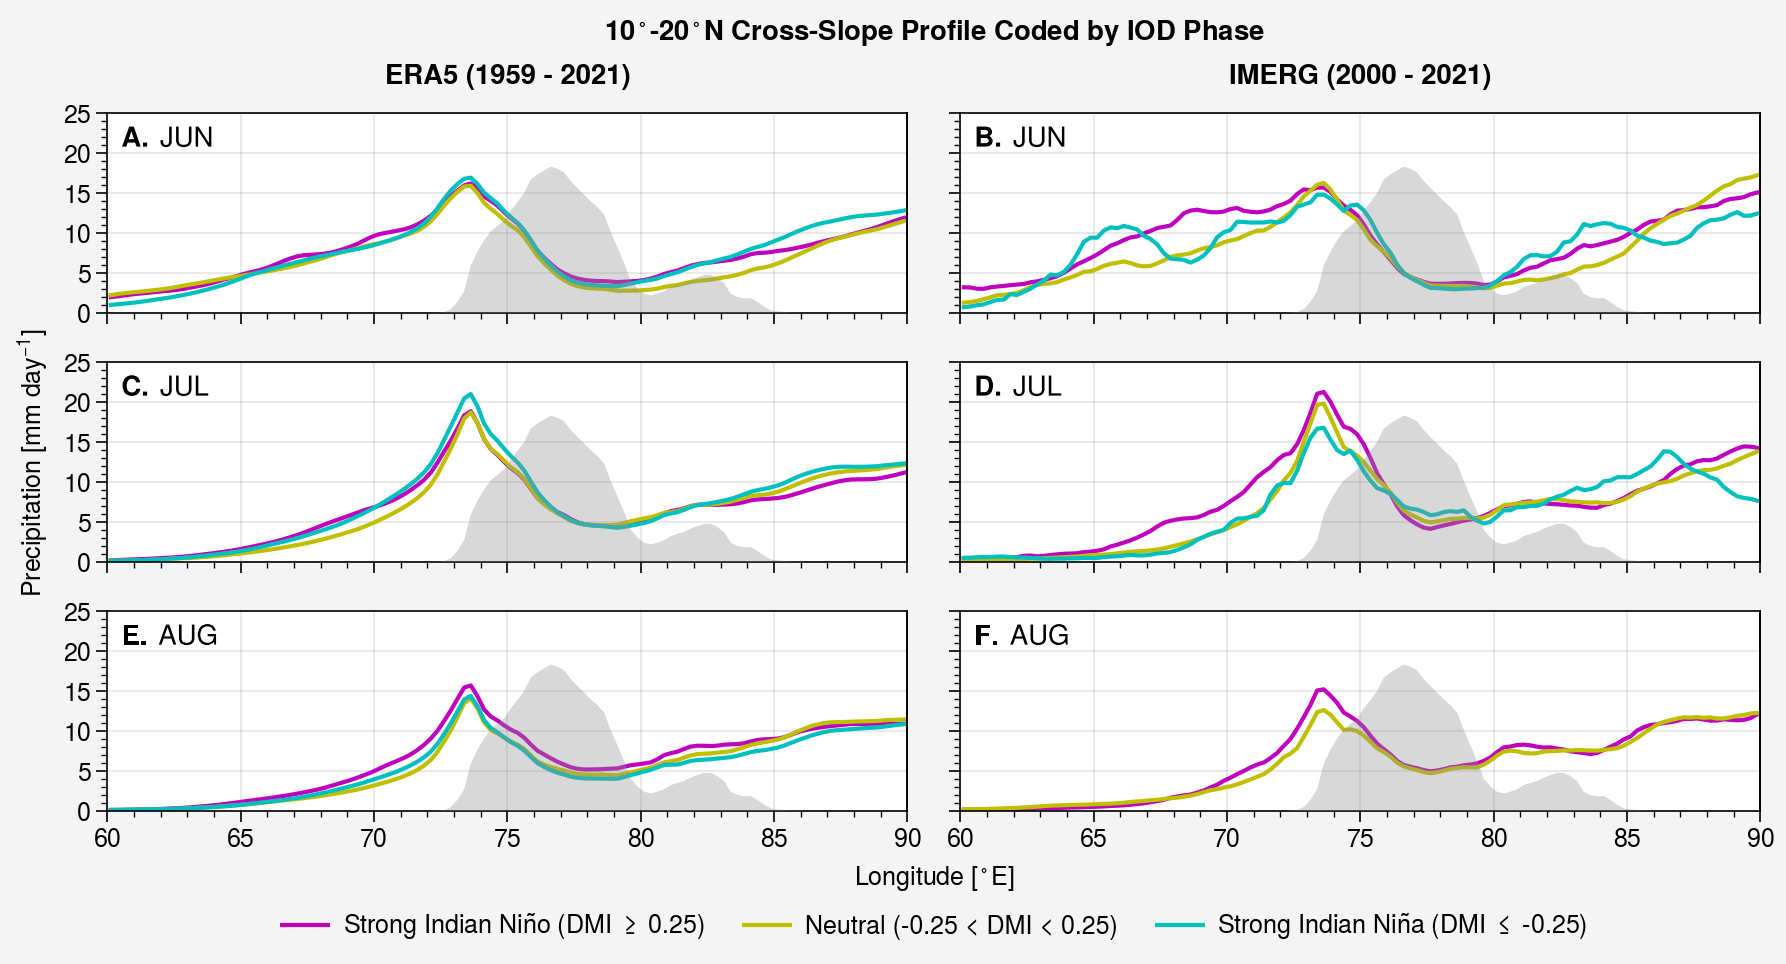

In [9]:
pplt.rc.reso='hi'
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle=str(lat1)+'$^\circ$-'+str(lat2)+'$^\circ$N Cross-Slope Profile Coded by IOD Phase',
           abc='A.',abcloc='ul',collabels=names,
           xlabel='Longitude [$^\circ$E]',xlim=(60,90),xticks=5,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,25),yticks=5) 
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,ax in enumerate(months):     
    m = axs[2*i].plot(lon,era5posdmi[i].mean(axis=0),colors='m',label=r'Strong Indian Ni$\tilde{n}$o (DMI $\geq$ 0.25)')
    y = axs[2*i].plot(lon,era5meddmi[i].mean(axis=0),colors='y',label='Neutral (-0.25 < DMI < 0.25)')    
    c = axs[2*i].plot(lon,era5negdmi[i].mean(axis=0),colors='c',label=r'Strong Indian Ni$\tilde{n}$a (DMI $\leq$ -0.25)')        
    axs[2*i].format(titleloc='ul',title=months[i])  
    axs[2*i+1].plot(lon,imergposdmi[i].mean(axis=0),colors='m')
    axs[2*i+1].plot(lon,imergmeddmi[i].mean(axis=0),colors='y')
    axs[2*i+1].plot(lon,imergnegdmi[i].mean(axis=0),colors='c')        
    axs[2*i+1].format(titleloc='ul',title=months[i])        
fig.legend((m,y,c),loc='b',ncols=3,frame=False)

## Plot Upwind Profiles of Precipitation by ENSO

In [10]:
era5medoni = xr.zeros_like(era5pr)
era5posoni = xr.zeros_like(era5pr)
era5negoni = xr.zeros_like(era5pr)
imergmedoni = xr.zeros_like(imergpr)
imergposoni = xr.zeros_like(imergpr)
imergnegoni = xr.zeros_like(imergpr)
for i,month in enumerate(months):
    for j in range(era5years):
        era5medoni[i,j] = era5pr[i,j].where(-0.5<era5oni[i,j]<0.5)
        era5posoni[i,j] = era5pr[i,j].where(era5oni[i,j]>=0.5)     
        era5negoni[i,j] = era5pr[i,j].where(era5oni[i,j]<=-0.5)   
    for k in range(imergyears):
        imergmedoni[i,k] = imergpr[i,k].where(-0.5<imergoni[i,k]<0.5)
        imergposoni[i,k] = imergpr[i,k].where(imergoni[i,k]>=0.5)      
        imergnegoni[i,k] = imergpr[i,k].where(imergoni[i,k]<=-0.5)

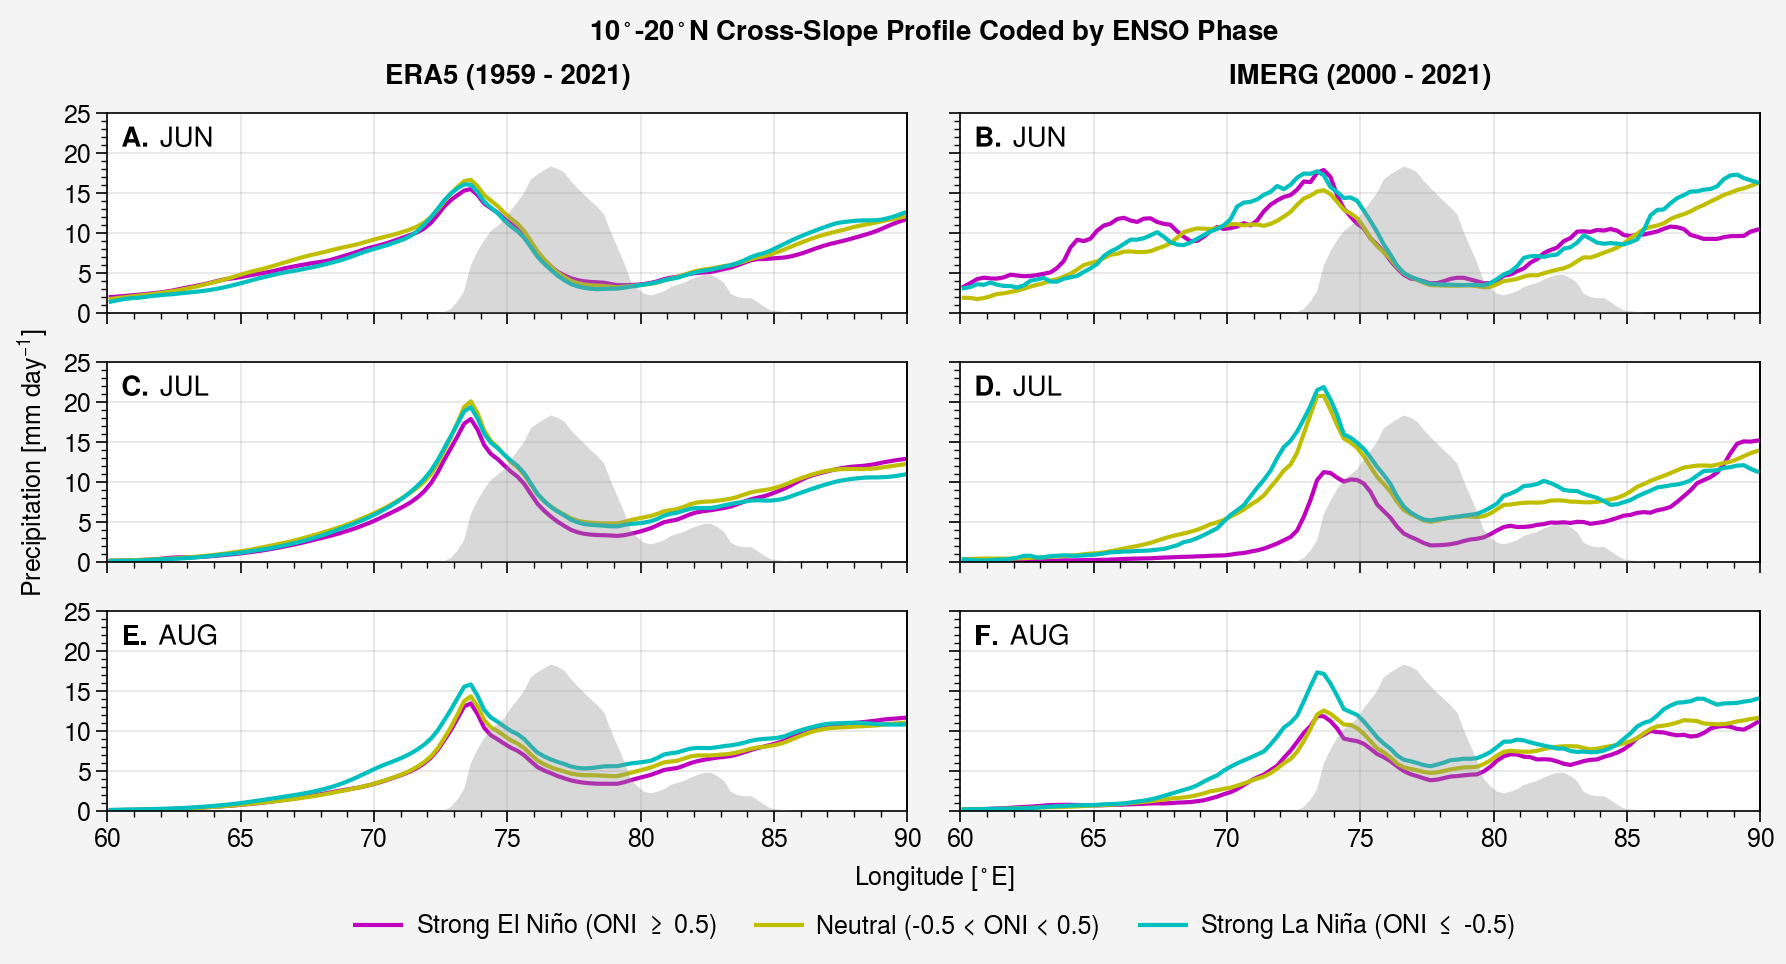

In [11]:
pplt.rc.reso='hi'
fig,axs = pplt.subplots(ncols=2,nrows=3,refwidth=4,refheight=1)
axs.format(suptitle=str(lat1)+'$^\circ$-'+str(lat2)+'$^\circ$N Cross-Slope Profile Coded by ENSO Phase',
           abc='A.',abcloc='ul',collabels=names,
           xlabel='Longitude [$^\circ$E]',xlim=(60,90),xticks=5,
           ylabel='Precipitation [mm day$^{-1}$]',ylim=(0,25),yticks=5) 
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylim=(0,0.8),ylabel='',yticks='null')
for i,ax in enumerate(months):      
    m = axs[2*i].plot(lon,era5posoni[i].mean(axis=0),colors='m',label=r'Strong El Ni$\tilde{n}$o (ONI $\geq$ 0.5)')
    y = axs[2*i].plot(lon,era5medoni[i].mean(axis=0),colors='y',label='Neutral (-0.5 < ONI < 0.5)')
    c = axs[2*i].plot(lon,era5negoni[i].mean(axis=0),colors='c',label=r'Strong La Ni$\tilde{n}$a (ONI $\leq$ -0.5)')        
    axs[2*i].format(titleloc='ul',title=months[i])  
    axs[2*i+1].plot(lon,imergposoni[i].mean(axis=0),colors='m')
    axs[2*i+1].plot(lon,imergmedoni[i].mean(axis=0),colors='y')
    axs[2*i+1].plot(lon,imergnegoni[i].mean(axis=0),colors='c')        
    axs[2*i+1].format(titleloc='ul',title=months[i])        
fig.legend((m,y,c),loc='b',ncols=3,frame=False)